In [55]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import os

In [69]:
# global config

# data path
root_dir = 'raw_data'
data_path_gpu = 'benchmark_121_put_active_cuda_640_100_600.txt'
data_path_cpu = 'benchmark_121_put_active_cpu_640_100_600.txt'

# set figure size and saving config
rc = {
    'figure.figsize':(12,8.27), 
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16, 
    'axes.titlesize': 20, 
    'axes.labelsize': 18
}
sns.set(rc=rc)

# plot title prefix 
plot_prefix = data_path_gpu.strip().split('_')[0:-2]
plot_prefix = '-'.join(plot_prefix)
print('[plot title prefix]', plot_prefix)

# figure save directory
save_dir = '_'.join(data_path_gpu.strip().split('_')[0:-4])
save_dict = dict()
if not os.path.exists(save_dir):
    print('creating saving directory')
    os.mkdir(save_dir)
print('[save to]', save_dir)

[plot title prefix] benchmark-121-put-active-cuda-640
[save to] benchmark_121_put_active


In [60]:
def raw_data_to_dataframe(gpu_data_path, cpu_data_path):
    """
    transfer raw data from test to pandas dataframe 
    example data frame: 
    [put_time]  [sender_num]  [platform]
    0.001           10            GPU-MPI
    0.0001          10            OPEN-MPI 
    ...  
    """
    pd_data = pd.DataFrame(columns = ['put_time', 'sender_num', 'platform'])
    # demo 
    # pd_data = pd_data.append({'sending_time': 0.001, 'thread_num': 10, 'platform': 'GPU-MPI'}, ignore_index=True)
    # pd_data = pd_data.append({'sending_time': 0.0001, 'thread_num': 10, 'platform': 'OPEN-MPI'}, ignore_index=True)

    # read gpu test file
    file = open(gpu_data_path, 'r')
    for line in file.readlines():
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'GPU-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    # read cpu test file 
    file = open(cpu_data_path, 'r')
    lines = file.readlines()
    for line in lines:
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'OPEN-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    return pd_data

In [70]:
# read data 
thread_time_data = raw_data_to_dataframe(os.path.join(root_dir, data_path_gpu), os.path.join(root_dir, data_path_cpu))
data_num = int(data_path_gpu.strip().split('_')[-3])

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/benchmark_121_put_active_cuda_640_100_600.txt'

In [5]:
def compute_average_total_time(data, data_num, data_size):
    pd_data = pd.DataFrame(columns = ['sender_num', 'platform', 'ave_total_time', 'data_num', 'data_size'])
    i = 0
    while i < len(data):
        # determine the thread number
        sender_num = data.loc[i, 'sender_num']
        
        # compute average total_time
        ave_total_time = np.mean(data.loc[i:i+sender_num-1, 'total_time'])
        
        # add row to new dataframe
        row = {
            'sender_num': sender_num, 
            'platform': data.loc[i, 'platform'], 
            'ave_total_time': ave_total_time, 
            'data_num': data_num, 
            'data_size': data_size, 
            'throughput[GB/s]': sender_num * data_num * data_size / ave_total_time / 1024 / 1024
        }
        pd_data = pd_data.append(row, ignore_index=True)
        
        i += sender_num
    
    return pd_data

In [71]:
block_data = compute_average_total_time(thread_time_data, data_num=data_num, data_size=8)  # double type = 8 bytes
block_data.to_csv(os.path.join(save_dir, 'block_data.csv'))
block_data

,sender_num,platform,ave_total_time,data_num,data_size,throughput[GB/s]
0,1,GPU-MPI,0.092570,640,8,0.052747
1,1,GPU-MPI,0.092599,640,8,0.052731
2,1,GPU-MPI,0.092771,640,8,0.052633
3,1,GPU-MPI,0.092756,640,8,0.052641
4,1,GPU-MPI,0.092701,640,8,0.052673
...,...,...,...,...,...,...
1921,30,OPEN-MPI,0.155265,640,8,0.943450
1922,30,OPEN-MPI,0.141210,640,8,1.037350
1923,30,OPEN-MPI,0.181077,640,8,0.808964
1924,30,OPEN-MPI,0.132062,640,8,1.109210


In [7]:
def data_validity_check(data):
    """
    check data validity from the log. 
    e.g. data point number.
    """
    # filter out platform data 
    cuda_mpi_data = data[data['platform'] == 'GPU-MPI']
    cpu_mpi_data = data[data['platform'] == 'OPEN-MPI']
    
    # create empty container
    result = data.drop(index=range(0, len(data)))
    
    # rule 1: data point number for each thread_num should be the same. 
    thread_num = data['sender_num'].unique()
    print('rule 1 check, sender_num = {}'.format(thread_num))
    expected = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == thread_num[0]])  # init with fisrt #(first cuda data point)
    for n in thread_num:
        _cpu = cpu_mpi_data[cpu_mpi_data['sender_num'] == n]
        _cuda = cuda_mpi_data[cuda_mpi_data['sender_num'] == n]
        len_cpu = len(cpu_mpi_data[cpu_mpi_data['sender_num'] == n])
        len_cuda = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == n])
        if len_cpu > expected:
            print('[warning] [cpu] sender_num = {}, sample {} out of {}'.format(n, expected, len_cpu))
            _cpu = _cpu.sample(n=expected)
        if len_cuda > expected:
            print('[warning] [cuda] sender_num = {}, sample {} out of {}'.format(n, expected, len_cuda))
            _cuda = _cuda.sample(n=expected)
        if len_cpu < expected:
            raise Exception('not enough data for [cpu] sender_num = {}, expect {} but get {}'.format(n, expected, len_cpu))
        if len_cuda < expected:
            raise Exception('not enough data for [cuda] sender_num = {}, expect {} but get {}'.format(n, expected, len_cuda))
        
        result = pd.concat([result, _cpu, _cuda])
    
    return result

In [8]:
thread_time_data[thread_time_data['platform'] == 'GPU-MPI']
thread_time_data[thread_time_data['platform'] == 'OPEN-MPI']

,put_time,sender_num,platform,total_time
4440,0.000012,1,OPEN-MPI,0.001166
4441,0.000003,1,OPEN-MPI,0.000336
4442,0.000003,1,OPEN-MPI,0.000327
4443,0.000003,1,OPEN-MPI,0.000324
4444,0.000003,1,OPEN-MPI,0.000323
...,...,...,...,...
9235,0.000243,30,OPEN-MPI,0.200000
9236,0.000283,30,OPEN-MPI,0.192336
9237,0.000280,30,OPEN-MPI,0.195997
9238,0.000281,30,OPEN-MPI,0.207995


In [9]:
# x = data_validity_check(thread_time_data)
back_up = thread_time_data.copy()  # leave a backup 
# thread_time_data = x
back_up

,put_time,sender_num,platform,total_time
0,0.000925,1,GPU-MPI,0.092570
1,0.000925,1,GPU-MPI,0.092599
2,0.000927,1,GPU-MPI,0.092771
3,0.000927,1,GPU-MPI,0.092756
4,0.000926,1,GPU-MPI,0.092701
...,...,...,...,...
9235,0.000243,30,OPEN-MPI,0.200000
9236,0.000283,30,OPEN-MPI,0.192336
9237,0.000280,30,OPEN-MPI,0.195997
9238,0.000281,30,OPEN-MPI,0.207995


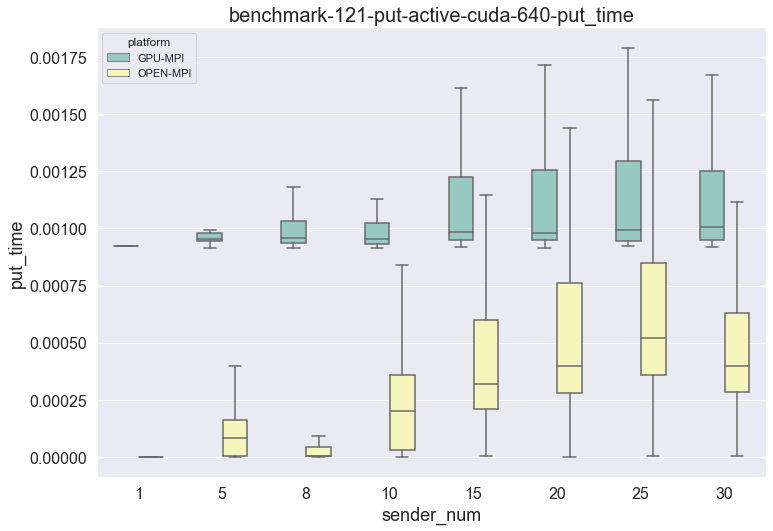

In [76]:
# general box plot
ax = sns.boxplot(x="sender_num", y="put_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, width=0.6)
ax.set_title(f'{plot_prefix}-put_time')
save_dict[f'{plot_prefix}-put_time-boxplot'] = ax

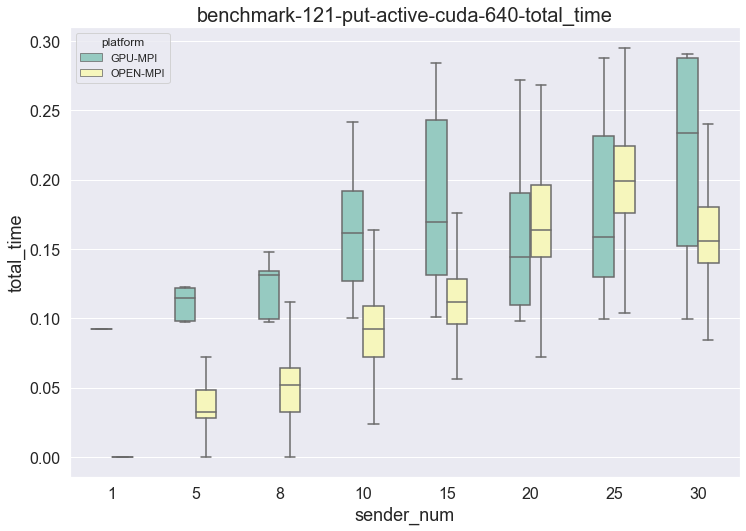

In [77]:
# general box plot for total time
ax = sns.boxplot(x="sender_num", y="total_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, width=0.5)
ax.set_title(f'{plot_prefix}-total_time')
save_dict[f'{plot_prefix}-total_time-boxplot'] = ax

In [78]:
# line plot for put time
def line_plot_median_quartile(time_key):
    ax = sns.lineplot(x="sender_num", y=time_key, hue='platform', data=thread_time_data, palette="Set2", estimator=np.median, ci=None)
    # generate quatile bound manually
    for p in thread_time_data['platform'].unique():
        data = thread_time_data[thread_time_data['platform'] == p]
        bounds = data.groupby('sender_num')[time_key].quantile((0.25,0.75)).unstack()
        ax.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1)
    return ax

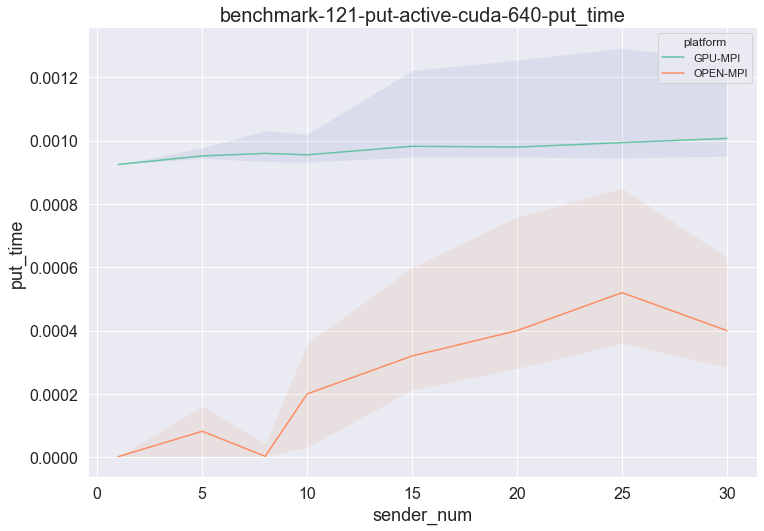

In [79]:
# line plot: put time, median-quartile
ax = line_plot_median_quartile(time_key='put_time')
ax.set_title(f'{plot_prefix}-put_time')
save_dict[f'{plot_prefix}-put_time-lineplot'] = ax

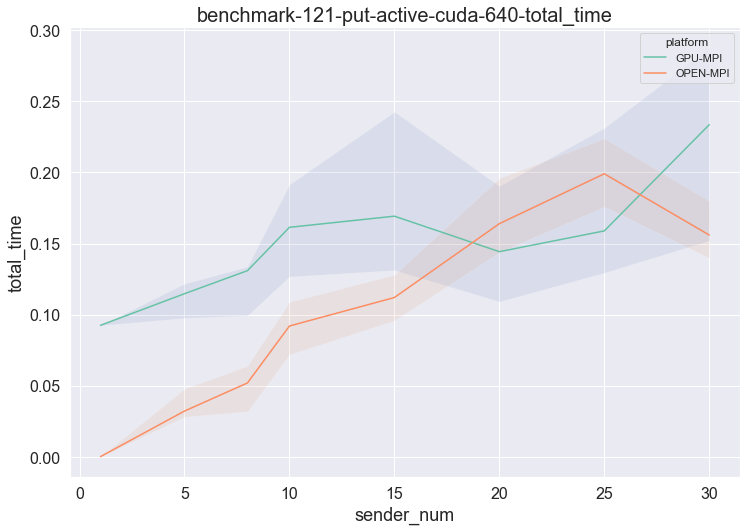

In [80]:
# line plot: total time, median-quartile
ax = line_plot_median_quartile(time_key='total_time')
ax.set_title(f'{plot_prefix}-total_time')
save_dict[f'{plot_prefix}-total_time-lineplot'] = ax

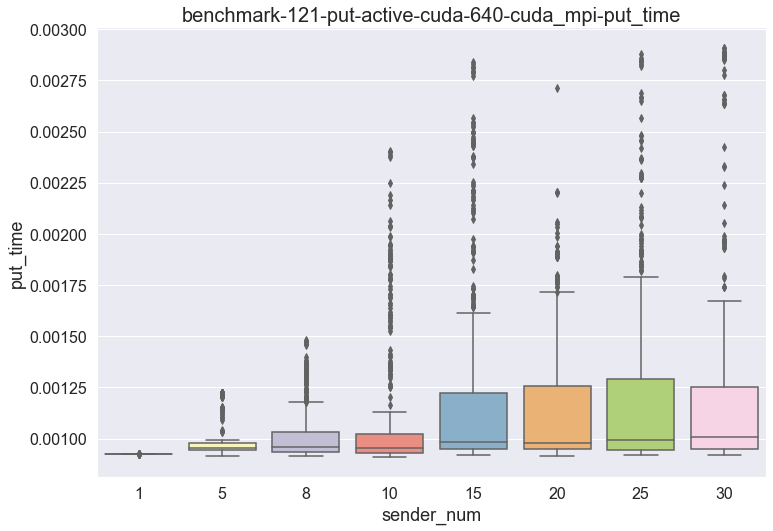

In [81]:
# subplot for gpu put time only 
data_gpu = thread_time_data[thread_time_data['platform'] == 'GPU-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_gpu, palette="Set3", showfliers=True) 
ax.set_title(f'{plot_prefix}-cuda_mpi-put_time')
save_dict[f'{plot_prefix}-cuda_mpi-put_time-boxplot'] = ax

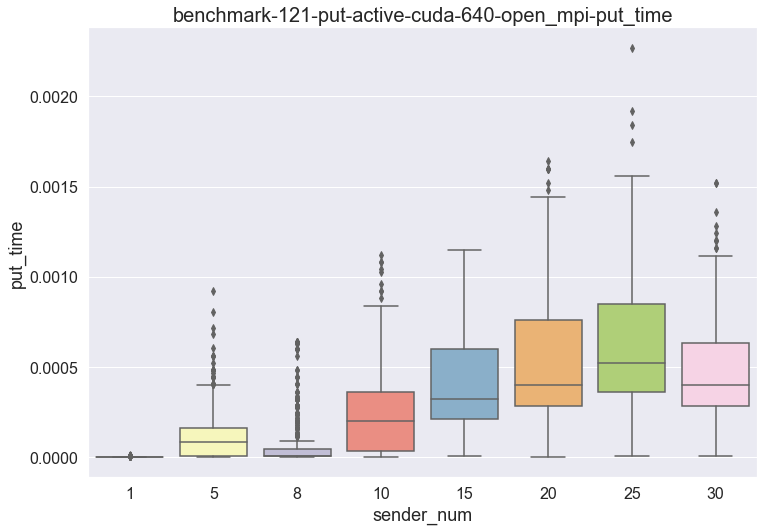

In [82]:
# subplot for cpu put time only 
data_cpu = thread_time_data[thread_time_data['platform'] == 'OPEN-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_cpu, palette="Set3")
ax.set_title(f'{plot_prefix}-open_mpi-put_time')
save_dict[f'{plot_prefix}-open_mpi-put_time-boxplot'] = ax

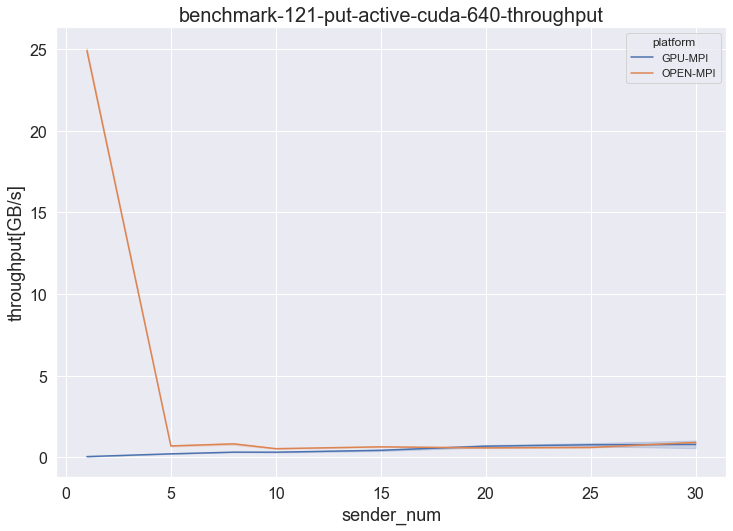

In [83]:
# throughput plot 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', hue='platform', data=block_data)
data_throughput.set_title(f'{plot_prefix}-throughput')
save_dict[f'{plot_prefix}-throughput-lineplot'] = data_throughput

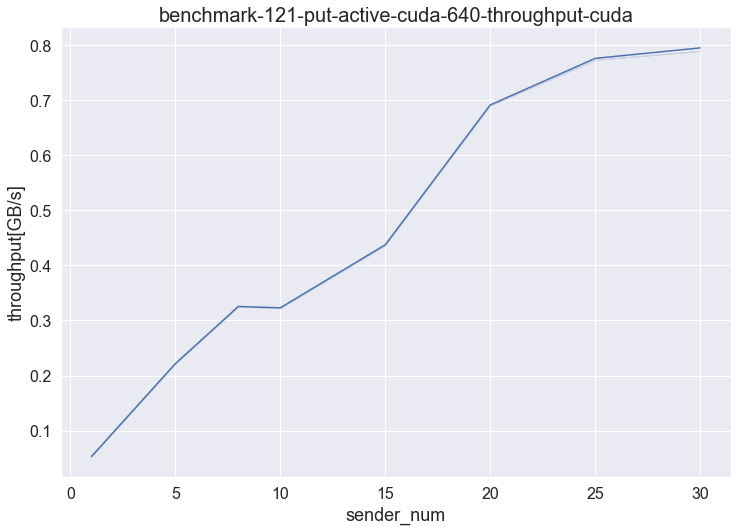

In [84]:
# throughput plot - gpu 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', data=block_data[block_data['platform'] == 'GPU-MPI'], ci=0)
data_throughput.set_title(f'{plot_prefix}-throughput-cuda')
save_dict[f'{plot_prefix}-throughput-cuda-lineplot'] = data_throughput

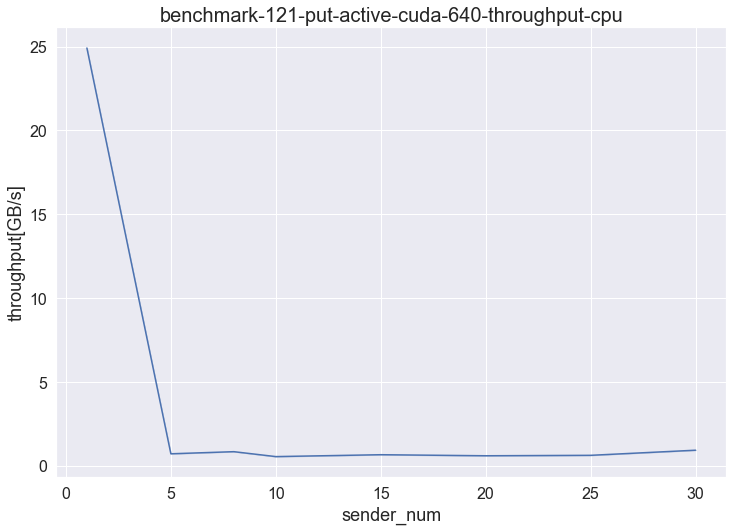

In [85]:
# throughput plot - cpu 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', data=block_data[block_data['platform'] == 'OPEN-MPI'], ci=0)
data_throughput.set_title(f'{plot_prefix}-throughput-cpu')
save_dict[f'{plot_prefix}-throughput-cpu-lineplot'] = data_throughput

In [86]:
# dump images
for k in save_dict:
    print(f'saving {k} ....')
    fig = save_dict[k].get_figure()
    fig.savefig(os.path.join(save_dir, f'{k}.pdf'))
    fig.savefig(os.path.join(save_dir, f'{k}.png'))
print('save figure done')

saving benchmark-121-put-active-cuda-640-put_time ....
saving benchmark-121-put-active-cuda-640-total_time ....
saving benchmark-121-put-active-cuda-640-put_time-boxplot ....
saving benchmark-121-put-active-cuda-640-total_time-boxplot ....
saving benchmark-121-put-active-cuda-640-put_time-lineplot ....
saving benchmark-121-put-active-cuda-640-total_time-lineplot ....
saving benchmark-121-put-active-cuda-640-cuda_mpi-put_time-boxplot ....
saving benchmark-121-put-active-cuda-640-open_mpi-put_time-boxplot ....
saving benchmark-121-put-active-cuda-640-throughput-lineplot ....
saving benchmark-121-put-active-cuda-640-throughput-cuda-lineplot ....
saving benchmark-121-put-active-cuda-640-throughput-cpu-lineplot ....
save figure done
